In [ ]:
# mount google drive
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
word_end = "-WORDS-updated.csv"
files = ['05LasTortillas_For Rebecca_Feb2023', '27ClimateChange_For Rebecca_Feb2023', '10ElTimbrePortatil_For Rebecca_Feb2023', '16.1TripToAfrica_for Rebecca', '03DosComadres_For Rebecca_Feb2023', '8.1-2GraduacionFamiliar_for Rebecca', '11 ElTrabajo_for Rebecca', '23ElPacifico_for Rebecca', '15LasCosasViejas_for Rebecca', '26LaPesca_for Rebecca']

In [ ]:
# load the excel data
import pandas as pd
import matplotlib.colors as mc # For the legend
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

filepath = "/content/drive/MyDrive/Code-Switching-Work/updated-data/"

In [ ]:
"""
This function loops through the entire transcript's tags in sequential order and
counts the number of lone tags that are S, E, or confused. It doesn't return
anything.

Input: list of lists of strings (assume it has already been passed through the
        filtering function).
"""
def count_lones(tag_col):
  prev = ""
  SL_count, EL_count, extra = 0, 0, 0
  lone_tracker = []
  for i, tags in enumerate(tag_col):
    for tag in tags:
      if tag == "L":
        if prev == "E":
          SL_count += 1
          lone_tracker.append("SL")
        elif prev == "S":
          EL_count += 1
          lone_tracker.append("EL")
        else:
          lone_tracker.append("LL")
          extra += 1
      prev = tag

  assert (SL_count + EL_count + extra == len(lone_tracker))
  print("Spanish Ls: ", SL_count)
  print("English Ls: ", EL_count)
  print("Extra Ls: ", extra)

In [ ]:
"""
This function goes through the tags in sequential order and changes the
lone tags to their respective language tag for the two scenarios:
  1) lone items are considered CS -> we flip the language from the prev tag
  2) lone items are not considered CS -> we keep the prev language tag.
Input: list of list of strings (assuming it has already been filtered)
Returns: (2) lists of lists of strings
  - Each list is populated through the loop. The lists within each list represent
    a single IU row of transcription (to account for future within vs. across CS).
    The -1 indexing in this function reporesents populating this most recent IU
    row with relevent language tags.
"""
def switch_Ls(tags_col):
  noCS, CS = [], []
  prev = ""
  for tags in tags_col:
    noCS.append([])
    CS.append([])
    for tag in tags:
      if tag == "L":
        if prev == "E":
          noCS[-1].append("E")
          CS[-1].append("S")
        elif prev == "S":
          noCS[-1].append("S")
          CS[-1].append("E")
      else:
        noCS[-1].append(tag)
        CS[-1].append(tag)
      prev = tag
  assert(len(noCS) == len(CS))
  return noCS, CS

In [ ]:
"""
This function counts the amounts of CS in the document, including the direction
of the switch (SE vs. ES).
Input:
  - tags_col: list of lists of strings. The innermost lists represent the IU
              rows of transcription.
"""
def count_CS(tags_col):
  prev = ""
  total = 0
  ES, SE = 0, 0
  for row in tags_col:
    for tag in row:
      # this statement means there's a switch
      if prev != "" and tag != prev:
        # per other literature, we are not counting CS out of a lone item
        if prev != "L":
          total += 1
          if prev == "E":
            ES += 1
          elif prev == "S":
            SE += 1
          else:
            print("ERROR!")
            return
      prev = tag
  assert(SE + ES == total)
  print("SE switches: ", SE)
  print("ES switches: ", ES)
  print("Total switches: ", total)

In [ ]:
"""
This function removes any irrelevant language tags given the language tag list.
It outputs a list of lists of strings.
"""
def filter_tags(tags_col):
  out = []
  for row in tags_col:
    if isinstance(row, str):
      filtered = [x for x in row if x in ["E", "S", "L"]]
      out.append(filtered)
    else:
      out.append([])
  return out

In [ ]:
"""
This function is meant to counts the CS within prosodic sentences and should only
be used for the IU level. Given the language tags and the actual words, it
sequentially checks through the transcript for a valid switch, dictated by tag
change and if it's within the prosodic sentence.

We do not return anything here, just print the metrics.
"""
def count_CS_prosodic(tags_col, word_col):
  #assert(len(tags_col) == len(word_col))
  print(tags_col)
  print(len(tags_col), len(word_col))
  prev = ""
  total = 0
  SE, ES = 0, 0
  for i, tags in enumerate(tags_col):
    for j, tag in enumerate(tags):
      if prev != "" and prev != tag: # there's a switch!
        # is it within the prosodic boundary?
        # the first condition checks if we're the 1st tag in our row AND the
        # previous character of the transcription line isn't the end of a prosodic
        # sentence. the second condition is if we're not the first tag in the IU.
        if (j == 0 and word_col[i - 1][-1] not in [".", "?"]) or j > 0:
            total += 1
            if prev == "E" and tag == "S":
              ES += 1
            elif prev == "S" and tag == "E":
              SE += 1
            elif tag == "L":
              if prev == "E":
                ES += 1
              elif prev == "S":
                SE += 1
            elif prev == "L":
              total -= 1
      prev = tag
  print("SE count: ", SE)
  print("ES count: ", ES)
  print("Total: ", total)
  assert (total == SE + ES)

In [ ]:
"""
This function calculates the normal I-Index using word tokens by going through
the transcript in sequential order. We only print the result, and don't return.
"""
def word_i_index(tag_cols):
  prev = ""
  total, switch_count = 0, 0
  for row in tag_cols:
    for tag in row:
      total += 1
      # remember, we aren't counting switching out of a lone tag.
      if prev != "" and prev != tag and prev != "L":
        switch_count += 1
      prev = tag

  i_index = switch_count / (total - 1)
  print("I-Index: ", i_index)
  return

def across_IU(tag_cols):
  prev = ""
  total, switch_count = 0, 0
  for row in tag_cols:
    if len(row) > 0:
      total += 1
    for i, tag in enumerate(row):
      if i == 0 and prev != "" and prev != tag and prev != "L":
        switch_count += 1
      prev = tag
  return switch_count, total

# Remember: this is a binary count that only counts once if a switch is present
# within the IU.
def within_IU(tag_cols):
  total, switch_count = 0, 0
  for row in tag_cols:
    if len(row) > 0:
      total += 1
      # the below is to ensure we don't double count, since an L will already
      # be considerd as an across IU switch
      if row[0] == "L":
        row = row[1:]
      unique_tags = set("".join(row))
      if len(unique_tags) > 1:
        switch_count += 1
  return switch_count, total

"""
This function calculates our unified proposed IU metric calculation. It only
prints, and does not return anything.
"""
def IU_i_index(tag_cols):
  # find across IU count
  across_count, across_total = across_IU(tag_cols)
  # find within IU count
  within_count, within_total = within_IU(tag_cols)
  print("Across IU raw count: ", across_count)
  print("Within IU raw count: ", within_count)
  within_I_index = within_count / within_total
  # find total eligible IUs
  print("Total Count: ", across_total)
  # calculate estimated raw IU count
  numerator = across_count + within_count - (across_count * within_I_index)
  print("Estimated raw numerator count: ", numerator)
  # calculate IU I Index
  print("IU I-Index: ", str(numerator/max(across_total, within_total)))
  return

"""
This function prints the number of valid tokens counted given a list of list
of strings.
"""
def valid_lang_tokens(tag_cols, token_level = "word"):
  S, E, L, total = 0, 0, 0, 0
  for row in tag_cols: # row is a list that could be empty
    if token_level == "word":
      for tag in row:
        if tag in ["E", "S", "L"]:
          total += 1
          if tag == "S":
            S += 1
          elif tag == "E":
            E += 1
          elif tag == "L":
            L += 1
    elif token_level == "IU":
      if len(row) > 0:
        tag = row[0]
        total += 1
        if tag == "S":
          S += 1
        elif tag == "E":
          E += 1
        elif tag == "L":
          L += 1

  assert (S + E + L == total)
  print("Number of S: ", S)
  print("Number of E: ", E)
  print("Total: ", total)
  return S, E

def m_index(S_count, E_count, k=2):
  total = S_count + E_count
  summation = (S_count / total) ** 2 + (E_count / total) ** 2
  num = 1 - summation
  m_ind = num / ((k - 1) * summation)
  print(f"M-Index: {m_ind}")
  return m_ind

In [ ]:
# Input: lang_tags is a list of lists
def visualize_transcript(filename, lang_tags):
    lang_distributions = []
    for tags in lang_tags:
      for tag in tags:
        if tag == "E":
          lang_distributions.append(0)
        elif tag == "S":
          lang_distributions.append(1)
    lang_distributions = np.asarray(lang_distributions).reshape(1, len(list(lang_distributions)), order="F")
    fig, ax = plt.subplots(figsize=(8, 4))
    cmap = matplotlib.colors.ListedColormap(["#0a437a", "#ADD8E6"])
    ax.pcolormesh(lang_distributions, cmap=cmap)
    ax.set_frame_on(False)
    plt.yticks([])
    ax.set_ylim(top=0.5)
    return

In [ ]:
def get_num_words(word_list):
  total = 0
  for tags in word_list:
    total += len(tags)
  return total

----
Information for file 05LasTortillas_For Rebecca_Feb2023
### IU TOKEN ###
Number of S:  1911
Number of E:  532
Total:  2453
M-Index: 0.5167299670008094
IU I-Index calculations (multi): 
Across IU raw count:  76
Within IU raw count:  6
Total Count:  2453
Estimated raw numerator count:  81.81410517733387
IU I-Index:  0.033352672310368474
Prosodic sentence switching (multi):
[['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], [], ['S'], ['S'], ['S'], ['S'], [], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], [], ['S'], ['S'], ['S'], ['S'], ['S'], [], ['S'], ['S'], ['S'], ['S'], ['S'], [], ['S'], [], ['S'], ['S'], ['S'], ['S'], ['S'], [], [], [], ['S'], [], [], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], [], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], [], ['S'], ['S'], ['S'], [], ['S'], ['S'], ['S'], [], ['S', 'S'], [], [], [], [], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], [], [], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'], ['S'],

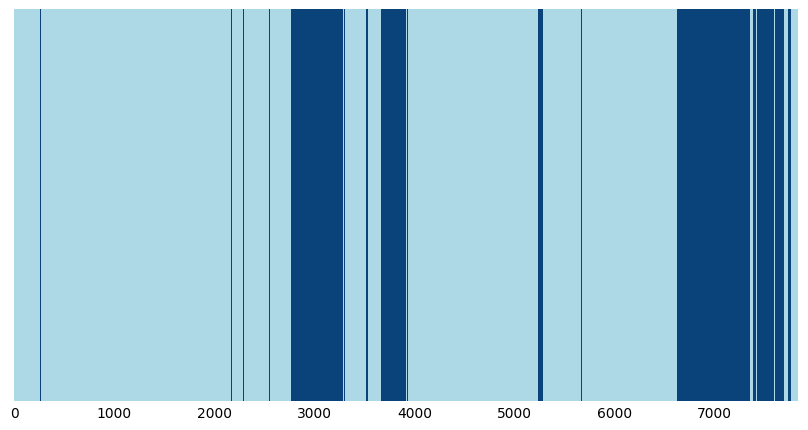

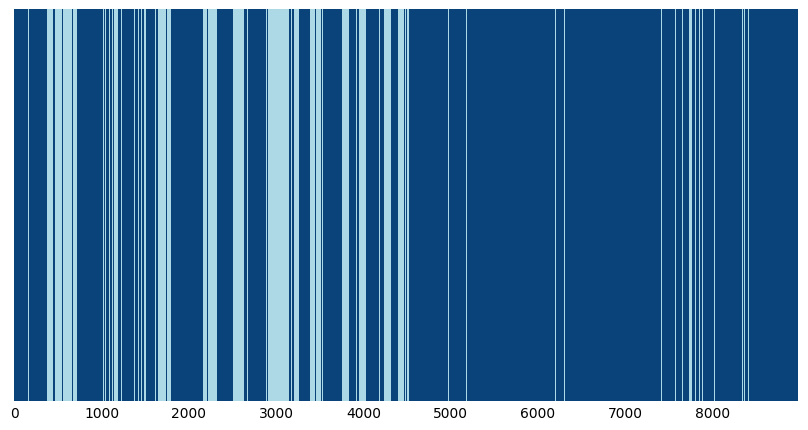

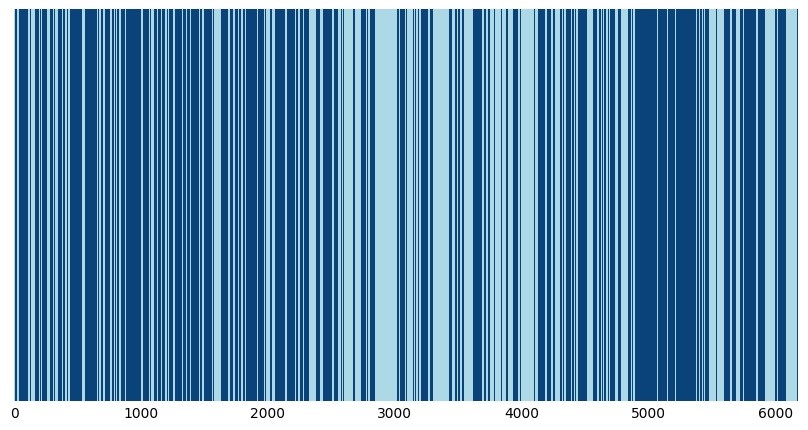

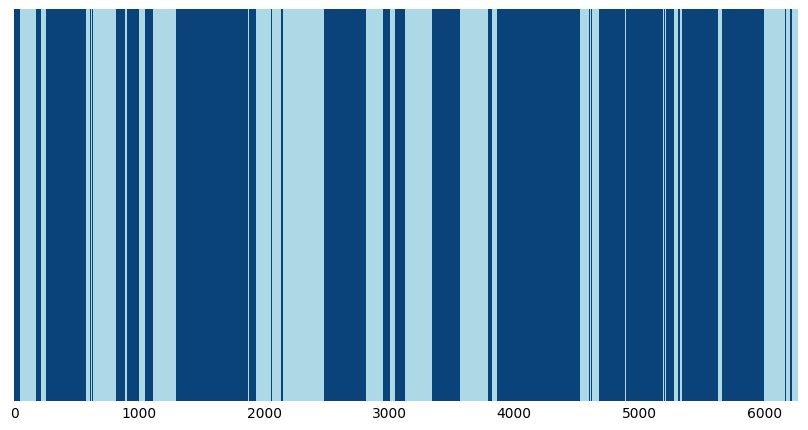

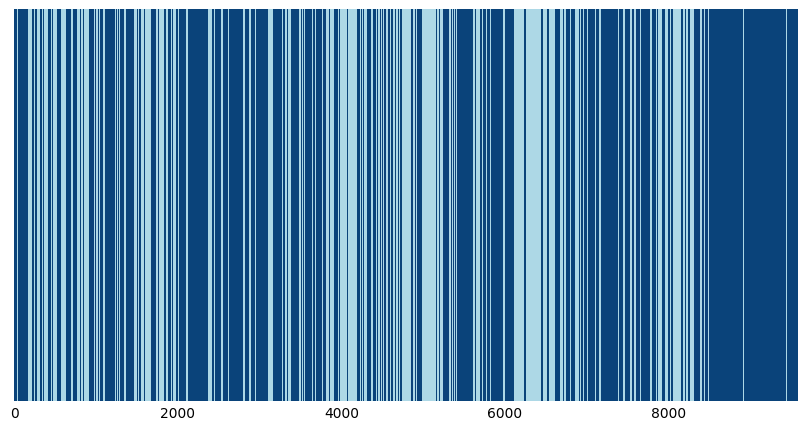

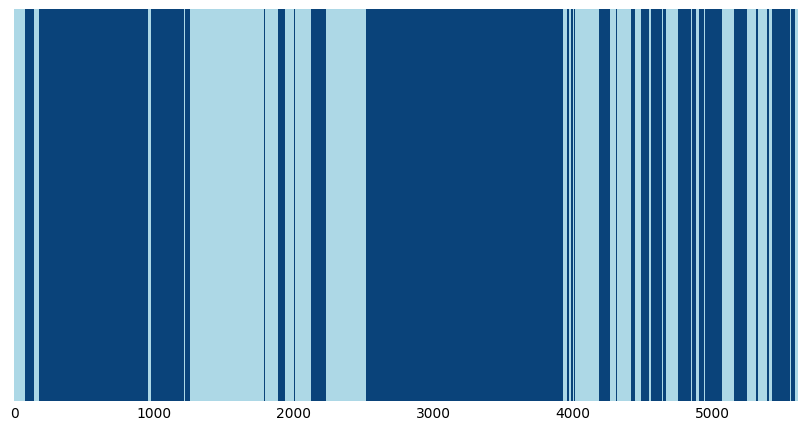

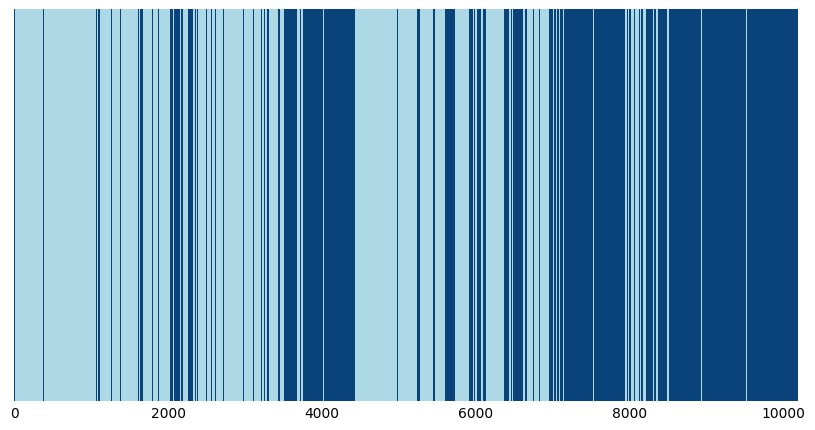

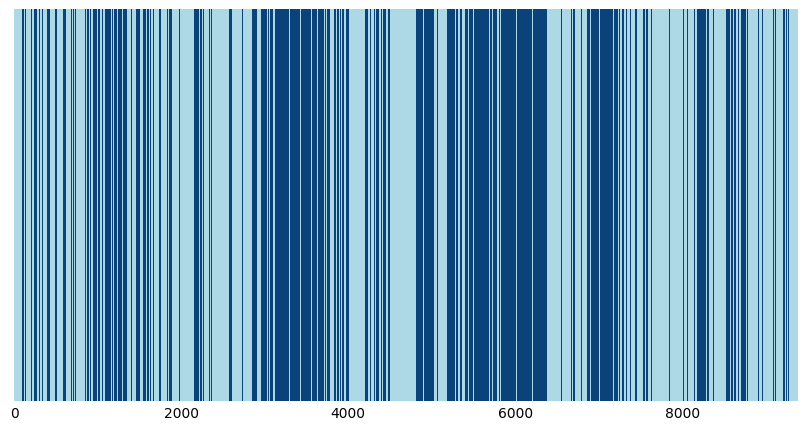

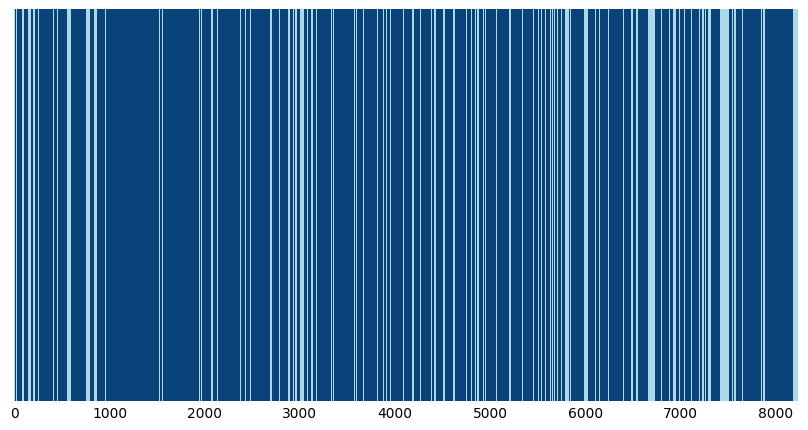

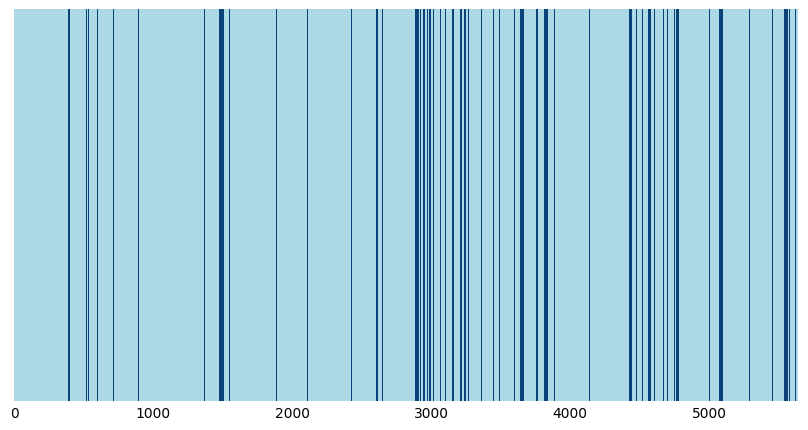

In [ ]:
for file in files:
  print("----")
  print("Information for file " + file)

  # STEP ONE: Read the files
  df_words = pd.read_csv(filepath + file + word_end)
  df_IUs = None
  if "16" in file or "15" in file:
    df_IUs = pd.read_excel(filepath + file + ".xlsm")
  else:
    df_IUs = pd.read_excel(filepath + file + ".xlsx")
  prev = ""
  ES_count, SE_count = 0, 0

  print("### IU TOKEN ###")
  filtered_IUs = filter_tags(df_IUs['Clean Lang Tag'])
  S_IU, E_IU = valid_lang_tokens(filtered_IUs, token_level="IU")
  m_index(S_IU, E_IU)
  #count_lones(filtered_IUs)
  noCS_IUs, CS_IUs = switch_Ls(filtered_IUs)
  assert(len(filtered_IUs) == len(CS_IUs))
  print("IU I-Index calculations (multi): ")
  IU_i_index(noCS_IUs)
  print("Prosodic sentence switching (multi):")
  count_CS_prosodic(noCS_IUs, df_IUs['IU'])
  print("IU I-Index calculations (both): ")
  IU_i_index(filtered_IUs)
  print("Prosodic sentence switching (BOTH):")
  count_CS_prosodic(filtered_IUs, df_IUs['IU'])

  print()
  print("### WORD TOKEN ###")
  filtered_words = filter_tags(df_words['Words Lang Tag'])
  S_word, E_word = valid_lang_tokens(filtered_words)
  m_index(S_word, E_word)
  count_lones(filtered_words)
  noCS_words, CS_words = switch_Ls(filtered_words)
  assert(len(filtered_words) == len(CS_words))
  print("WHEN Ls are not counted as CS:")
  valid_lang_tokens(filtered_words)
  count_CS_prosodic(noCS_words, df_IUs['IU'])
  print("Word I-Index (multi): ")
  word_i_index(noCS_words)
  print("WHEN Ls ARE counted as CS:")
  count_CS_prosodic(filtered_words, df_IUs['IU'])
  print("Word I-Index (both): ")
  word_i_index(filtered_words)
  visualize_transcript(file, filtered_words)

  print("-----")
  print(f"Number of IUs: {len(filtered_IUs)}")
  print(f"Number of words: {get_num_words(filtered_words)}")

  print()
  print()
  print()